# Heart Attack Analysis & Prediction Project

Project goal: to perform exploratory data analysis on heart attack data and predict the chance of getting heart attack.
Dataset avaliable on Kaggle:
https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset?select=heart.csv

Data Dictionary

Target: heart attack (0 - less chance of heart attack, 1 - more chance of heart attack)

Age: age of the patient,
Sex: sex of the patient (0 - Female, 1- Male),
cp: chest pain type chest pain type (0 - typical angina, 1 - atypical angina, 2 - non-anginal pain, 3 - asymptomatic),
trtbps: resting blood pressure (in mm Hg),
chol: cholestoral in mg/dl fetched via BMI sensor,
fbs: (fasting blood sugar > 120 mg/dl) (1 - true, 0 - false),
restecg: resting electrocardiographic results (0 - normal, 1 - having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2 - showing probable or definite left ventricular hypertrophy by Estes' criteria),
thall: thalium stress test result (0 - NA, 1 - fixed defect, 2 - normal blood flow, 3 - reversible defect),
thalach: maximum heart rate achieved (bpm),
exang: exercise induced angina (1 - yes; 0 - no),
oldpeak: previous peak value,
slp: slope (0 - downsloping, 1 - flat, 2 - upsloping),
caa: number of major vessels (0-3),
o2saturation: oxygen saturation level

Packages import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
sns.set_style("darkgrid")
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import plotly.io as pio
pio.renderers.default = "svg"

Data

In [2]:
df1 = pd.read_csv('Datasets/heart.csv')
df2 = pd.read_csv('Datasets/o2Saturation.csv', names=['o2Saturation'])

In [3]:
df = df1.merge(df2, left_index=True, right_index=True)

In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output', 'o2Saturation'],
      dtype='object')

In [5]:
df.rename(columns={'trtbps': 'bld_pressure',
                   'thalachh':'max_heart_rate',
                   'exng':'angina',
                   'caa': 'n_vessels',
                   'output':'heart_attack'},
          inplace=True)

In [6]:
df.head(n=8)

,age,sex,cp,bld_pressure,chol,fbs,restecg,max_heart_rate,angina,oldpeak,slp,n_vessels,thall,heart_attack,o2Saturation
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,98.6
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,98.6
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,98.6
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,98.6
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,98.1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,97.5
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,97.5
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,97.5


In [7]:
df.shape

(303, 15)

In [8]:
df.dtypes

age                 int64
sex                 int64
cp                  int64
bld_pressure        int64
chol                int64
fbs                 int64
restecg             int64
max_heart_rate      int64
angina              int64
oldpeak           float64
slp                 int64
n_vessels           int64
thall               int64
heart_attack        int64
o2Saturation      float64
dtype: object

In [9]:
#Missing values check:

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

age - 0%
sex - 0%
cp - 0%
bld_pressure - 0%
chol - 0%
fbs - 0%
restecg - 0%
max_heart_rate - 0%
angina - 0%
oldpeak - 0%
slp - 0%
n_vessels - 0%
thall - 0%
heart_attack - 0%
o2Saturation - 0%


In [10]:
#Separating the columns in categorical, continuous and target features

target_feature=['heart_attack']
cat_features = ['sex', 'cp', 'fbs', 'restecg', 'angina', 'slp', 'n_vessels', 'thall']
con_features = ['age', 'bld_pressure', 'chol', 'max_heart_rate', 'oldpeak', 'o2Saturation']

# EDA

In [11]:
df[con_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
bld_pressure,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
max_heart_rate,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2
o2Saturation,303.0,97.484488,0.352649,96.5,97.5,97.5,97.5,98.6


Correlation matrix

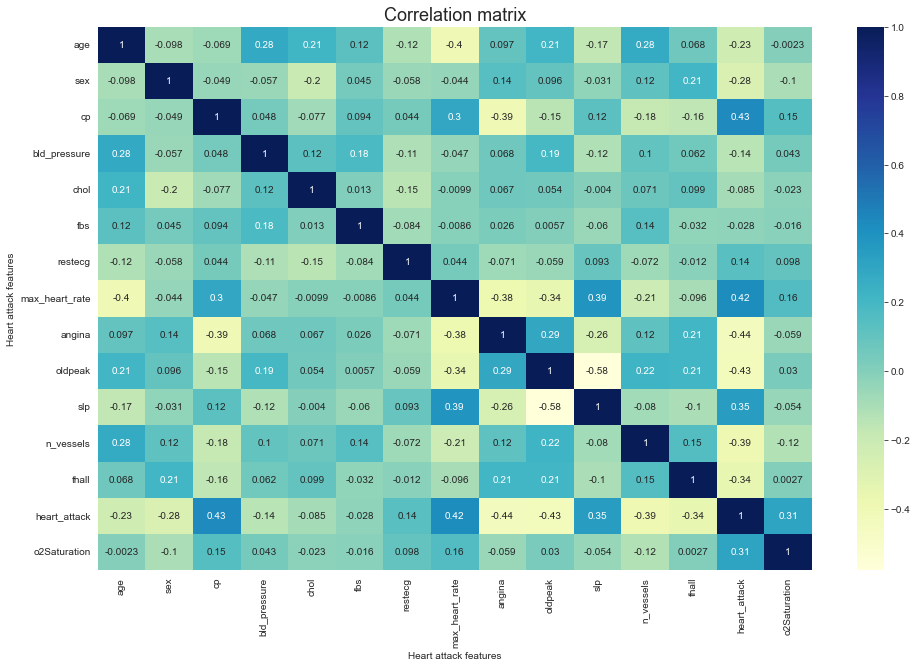

In [12]:
from matplotlib.pyplot import figure
%matplotlib inline
matplotlib.rcParams['figure.figsize']=(16,10)

corr_matrix=df.corr(method='pearson')
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True)
plt.title('Correlation matrix', fontsize=18)
plt.xlabel('Heart attack features', fontsize=10)
plt.ylabel('Heart attack features', fontsize=10)
plt.show()

It can be seen that there is not any strong correlation between the target (heart_attack) and heart attack variables. The variables that correlate the most are:
positively: cest pain (cp, corr coef: 0.43), max heart rate (corr coef: 0.42)
negatively: angina (corr coef: -0.44), old peak (corr coef: -0.43)

Among heart attack features, the highest correlation can be noted between slope (slp) and old peak (corr coef: -0.58)

Categorical features distribution and analysis

1    207
0     96
Name: sex, dtype: int64

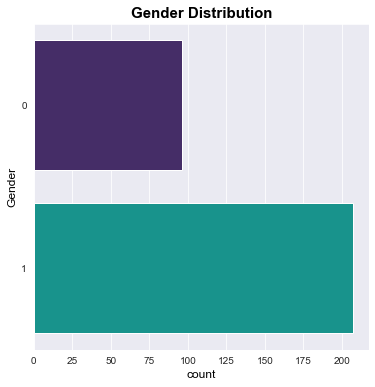

In [13]:
fig, ax1 = plt.subplots(figsize=(6, 6))
ax1 = sns.countplot(y ='sex', data = df, palette=['#432371','#03A89E'])
ax1.set_title('Gender Distribution', fontsize=15, fontweight='bold', color='black')
ax1.set_xlabel('count', fontsize=12, color='black')
ax1.set_ylabel('Gender', fontsize=12, color='black')

df.sex.value_counts()

207 - Males and 96 - Females. The number of males is more than twice the number of females.

1    165
0    138
Name: heart_attack, dtype: int64

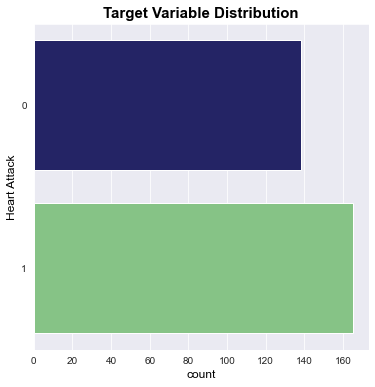

In [14]:
fig, ax2 = plt.subplots(figsize=(6, 6))
ax2 = sns.countplot(y ='heart_attack', data = df, palette=['#191970', '#7CCD7C'])
ax2.set_title('Target Variable Distribution', fontsize=15, fontweight='bold', color='black')
ax2.set_xlabel('count', fontsize=12, color='black')
ax2.set_ylabel('Heart Attack', fontsize=12, color='black')

df.heart_attack.value_counts()

 138 persons have less chance of heart attack
 165 persons have more chance of heart attack

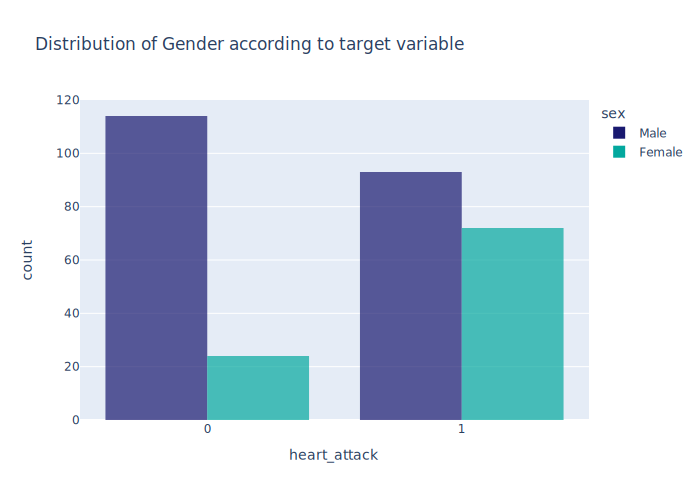

In [15]:
fig=px.histogram(df, x='heart_attack', color='sex', 
                color_discrete_map = {0:'#03A89E',1:'#191970'},
                title="Distribution of Gender according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'Female', '1': 'Male'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

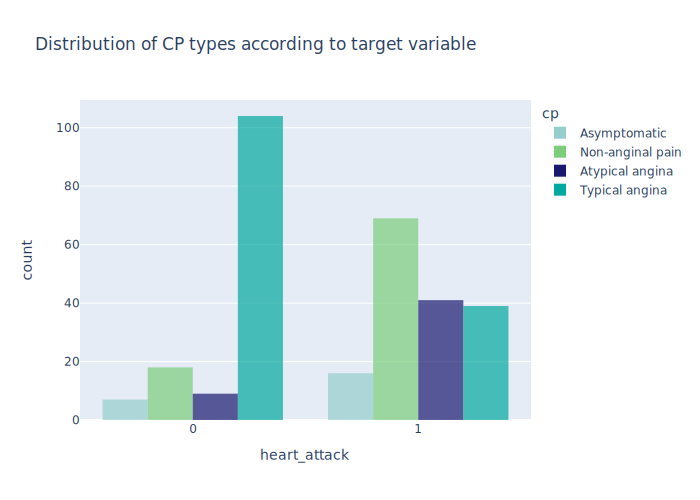

In [16]:
fig=px.histogram(df, x='heart_attack', color='cp', 
                color_discrete_map = {0:'#03A89E',1:'#191970', 2: '#7CCD7C', 3: '#96CDCD'},
                title="Distribution of CP types according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'Typical angina', '1': 'Atypical angina', '2':'Non-anginal pain', '3':'Asymptomatic'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Most of the patients (104) with less chance of heart attack have chest pain type: typical angina. On the contrary, patients with more chance of heart attack mostly have non-anginal pain. 

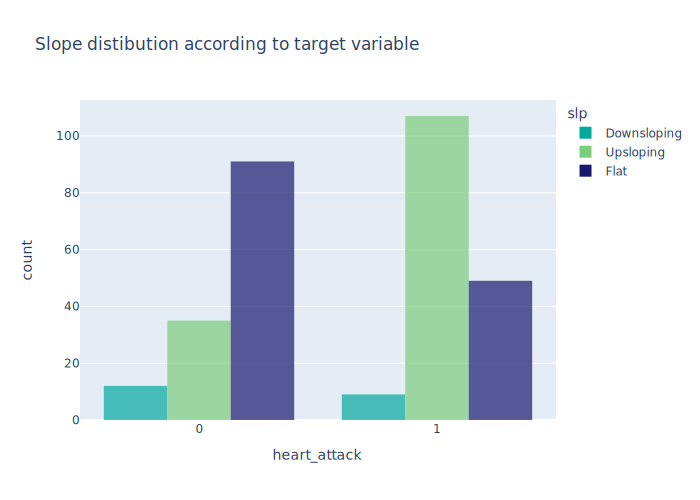

In [17]:
fig=px.histogram(df, x='heart_attack', color='slp', 
                color_discrete_map = {0:'#03A89E',1:'#191970', 2: '#7CCD7C'},
                title="Slope distibution according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'Downsloping', '1': 'Flat', '2':'Upsloping'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Patients with less chances of heart attack in most cases have flat slope of the peak exercise ST segment, whereas patients with more chances of heart attack usually have upsloping slope.

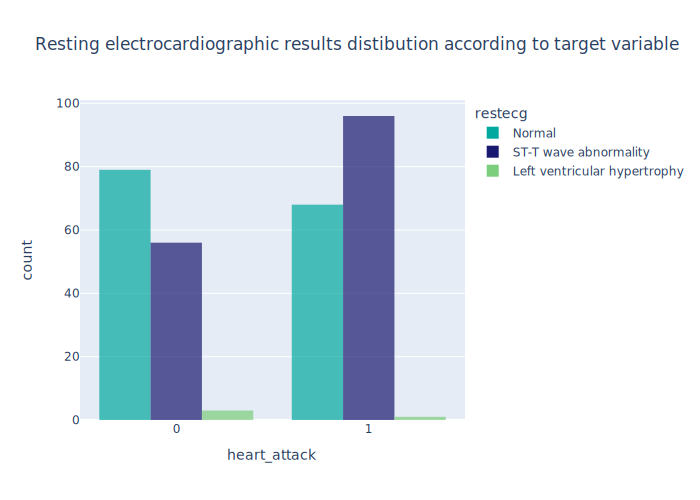

In [18]:
fig=px.histogram(df, x='heart_attack', color='restecg', 
                color_discrete_map = {0:'#03A89E',1:'#191970', 2: '#7CCD7C'},
                title="Resting electrocardiographic results distibution according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'Normal', '1': 'ST-T wave abnormality', '2':'Left ventricular hypertrophy'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Patients with ST-T wave abnormality of resting electrocardiographic have higher chance of heart attack.

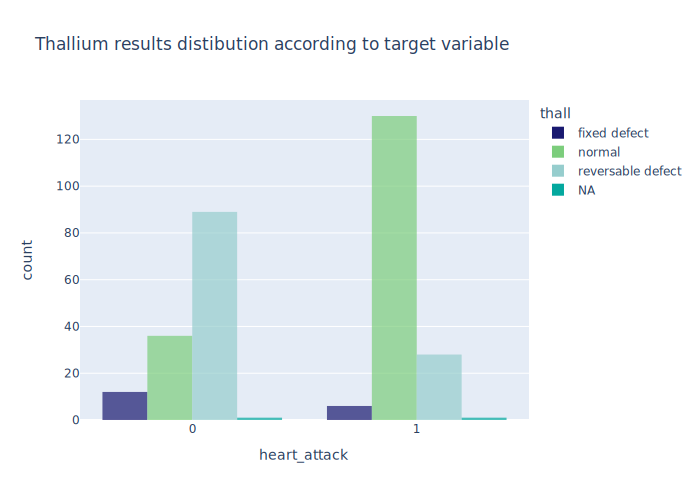

In [19]:
fig=px.histogram(df, x='heart_attack', color='thall', 
                color_discrete_map = {0:'#03A89E',1:'#191970', 2: '#7CCD7C', 3: '#96CDCD'},
                title="Thallium results distibution according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'NA', '1': 'fixed defect', '2':'normal', '3':'reversable defect'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Patients with normal thallium stress test results have much higher chance of heart attack than others.

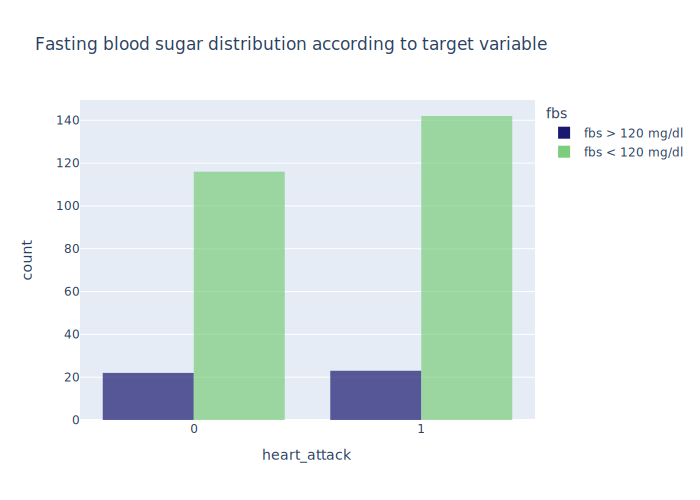

In [20]:
fig=px.histogram(df, x='heart_attack', color='fbs', 
                color_discrete_map = {0:'#7CCD7C',1:'#191970'},
                title="Fasting blood sugar distribution according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'fbs < 120 mg/dl', '1': 'fbs > 120 mg/dl'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

According to the histogram, for the majority of people from both groups (with high and low chance of heart attack) fasting blood sugar value is less than 120 mg/dl

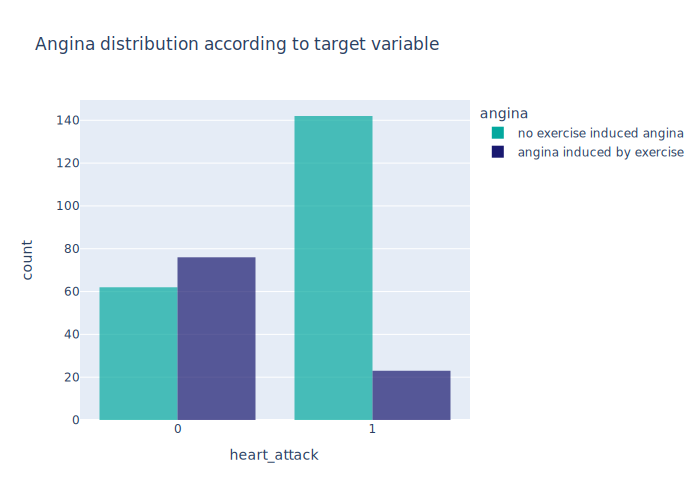

In [21]:
fig=px.histogram(df, x='heart_attack', color='angina', 
                color_discrete_map = {0:'#03A89E',1:'#191970'},
                title="Angina distribution according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'no exercise induced angina', '1': 'angina induced by exercise'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Patients with no exercise induced angina have higher chance of heart attack.

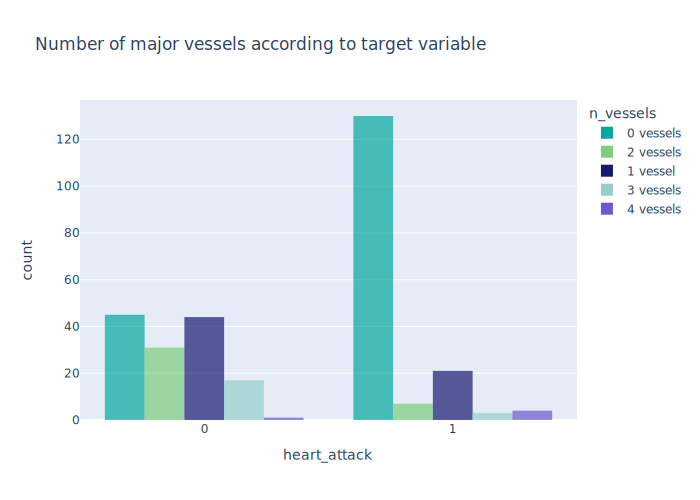

In [22]:
fig=px.histogram(df, x='heart_attack', color='n_vessels', 
                color_discrete_map = {0:'#03A89E',1:'#191970', 2: '#7CCD7C', 3: '#96CDCD', 4: '#6A5ACD'},
                title="Number of major vessels according to target variable", barmode="group", opacity=0.7)


upd_names = {'0':'0 vessels', '1': '1 vessel', '2':'2 vessels', '3':'3 vessels', '4':'4 vessels'}
fig.for_each_trace(lambda t: t.update(name = upd_names[t.name],
                                      legendgroup = upd_names[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, upd_names[t.name])
                                     )
                  )
fig.show()

Patients with number of major vessels equals to 0 have much higher chance of heart attack

Continuous features

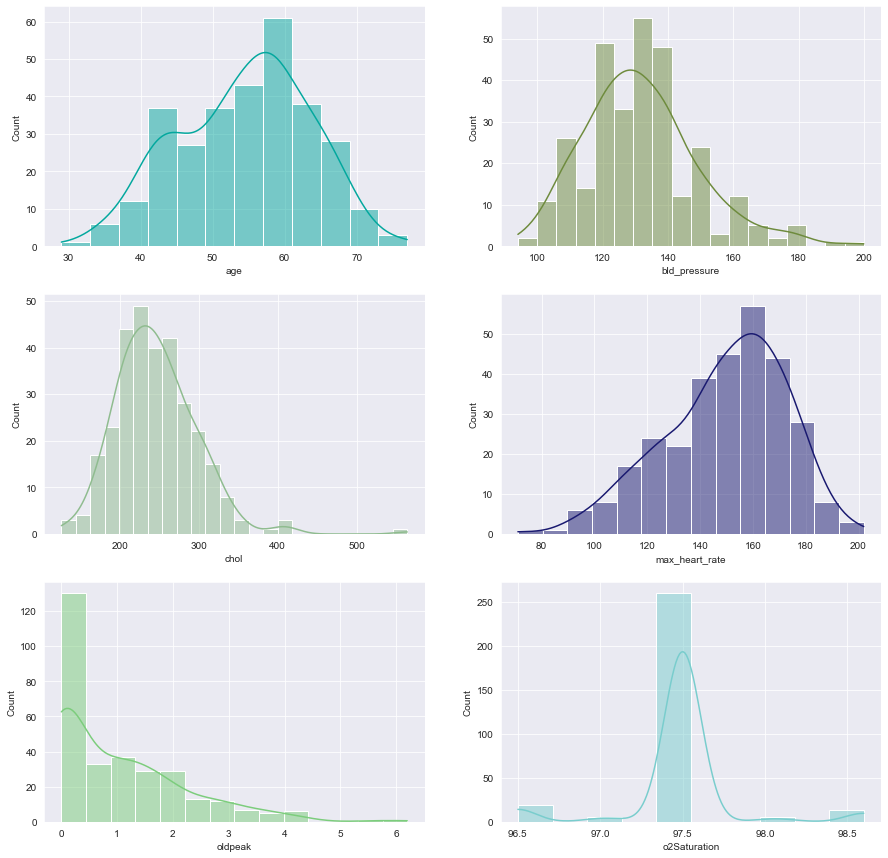

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.histplot(data=df, x='age', kde=True, color='#03A89E', ax=axs[0, 0])
sns.histplot(data=df, x='bld_pressure', kde=True, color='#6E8B3D', ax=axs[0, 1])
sns.histplot(data=df, x='chol', kde=True, color='#8FBC8F', ax=axs[1, 0])
sns.histplot(data=df, x='max_heart_rate', kde=True, color='#191970', ax=axs[1, 1])
sns.histplot(data=df, x='oldpeak', kde=True, color='#7CCD7C', ax=axs[2, 0])
sns.histplot(data=df, x='o2Saturation', kde=True, color='#79CDCD', ax=axs[2, 1])

plt.show()

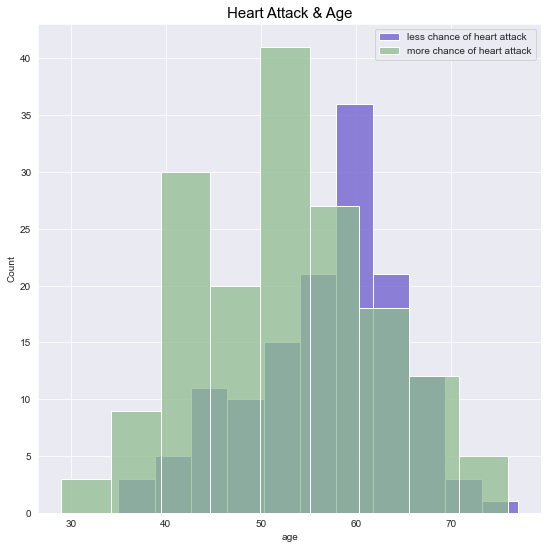

In [24]:
plt.figure(figsize=(9,9))
sns.histplot(df[df['heart_attack'] == 0]['age'], color= '#6A5ACD', label='less chance of heart attack') 
sns.histplot(df[df['heart_attack'] == 1]['age'], color='#8FBC8F', label='more chance of heart attack')
plt.title('Heart Attack & Age', fontsize=15, color='black')
plt.legend()
plt.show()

People between the ages of 50-55 have more chances of heart attack than people in their early 60s.

Boxplots (Outliers detection) and continuous features distribution according to target variable

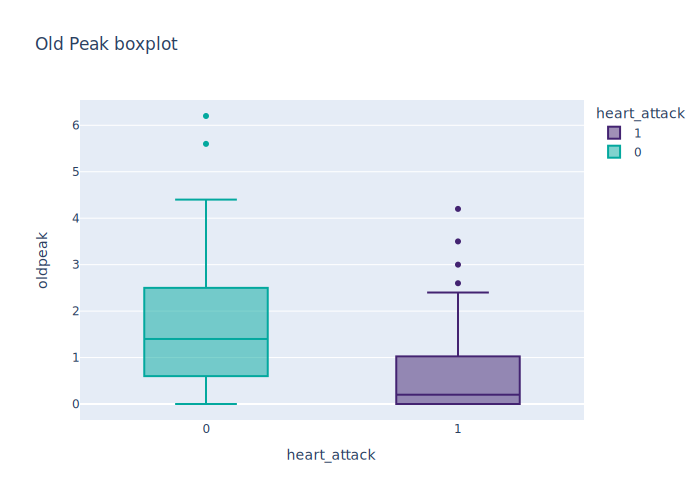

In [25]:
fig = px.box(df,y='oldpeak',x="heart_attack",color='heart_attack', title="Old Peak boxplot",
            color_discrete_sequence=['#432371','#03A89E'])
fig.show()

[Text(0.5, 1.0, 'oldpeak')]

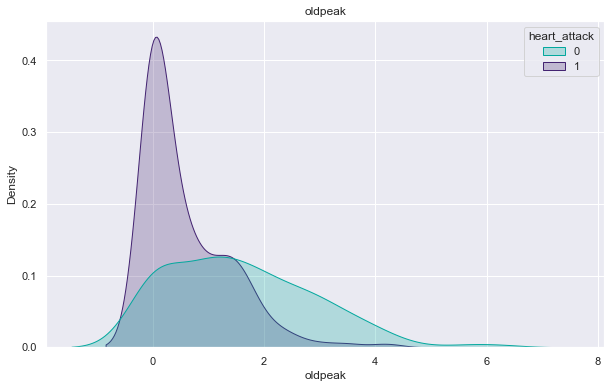

In [26]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.kdeplot(data=df,x='oldpeak', hue='heart_attack', fill=True, palette = ['#03A89E', '#432371']).set(
    title="oldpeak")

People with lower value of previous (old) peak have higher chances of heart attack.

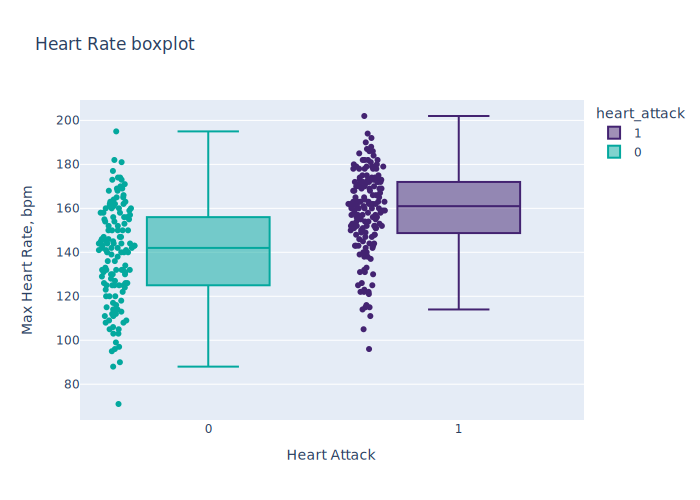

In [27]:
fig = px.box(df,y='max_heart_rate',x="heart_attack",color='heart_attack', 
             title='Heart Rate boxplot', points="all", color_discrete_sequence=['#432371','#03A89E'])
fig.update_layout(xaxis_title='Heart Attack', yaxis_title='Max Heart Rate, bpm')
fig.show()

[Text(0.5, 1.0, 'Max heart rate')]

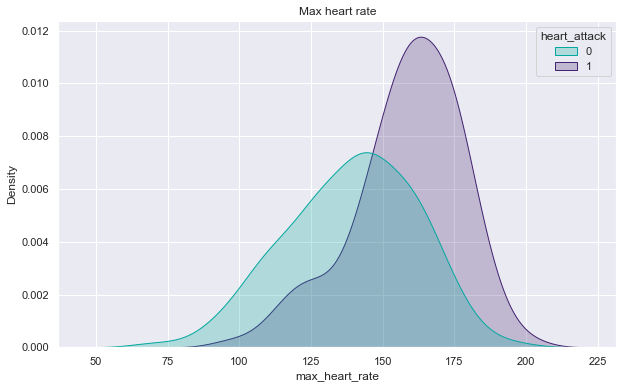

In [28]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.kdeplot(data=df,x='max_heart_rate', hue='heart_attack', fill=True, palette = ['#03A89E', '#432371']).set(
    title="Max heart rate")

People with lower maximum heart rate have less chance of getting a heart attack. For the most people with higher chance of heart attack the max heart rate is between 150 - 180 bpm.

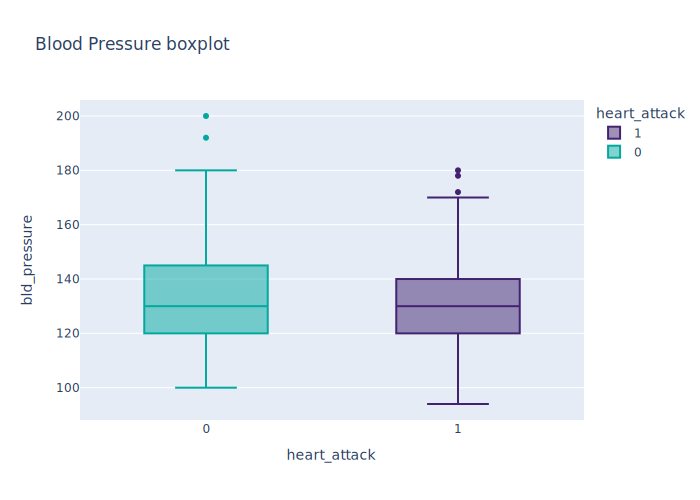

In [29]:
fig = px.box(df,y='bld_pressure',x="heart_attack",color='heart_attack', title="Blood Pressure boxplot",
            color_discrete_sequence=['#432371','#03A89E'])
fig.show()

[Text(0.5, 1.0, 'Blood pressure')]

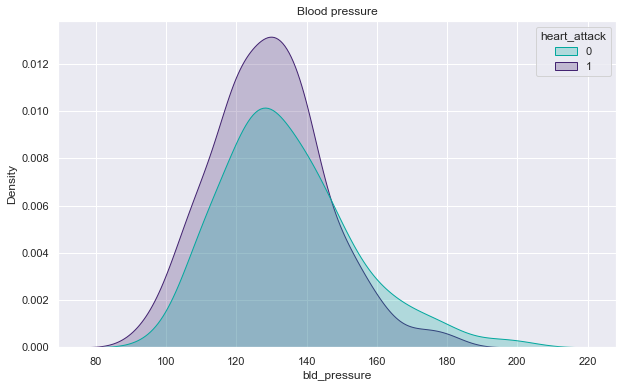

In [30]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.kdeplot(data=df,x='bld_pressure', hue='heart_attack', fill=True, palette = ['#03A89E', '#432371']).set(
    title="Blood pressure")

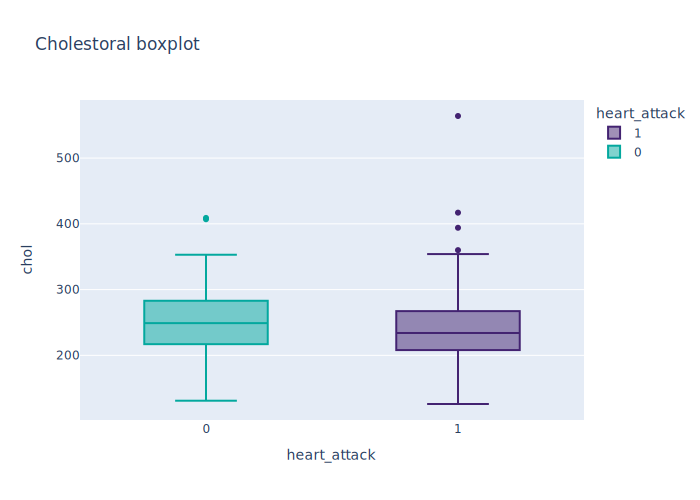

In [31]:
fig = px.box(df,y='chol',x="heart_attack",color='heart_attack', title="Cholestoral boxplot",
            color_discrete_sequence=['#432371','#03A89E'])
fig.show()


[Text(0.5, 1.0, 'Cholestoral')]

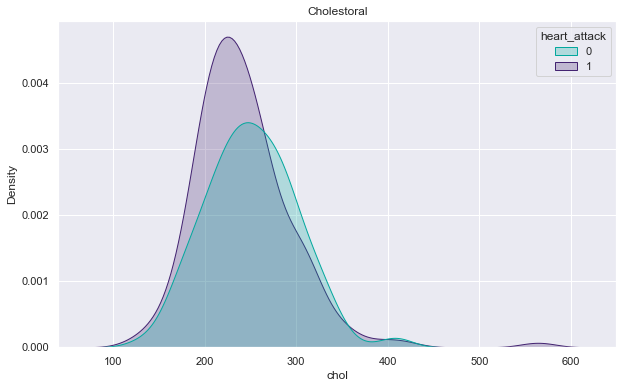

In [32]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.kdeplot(data=df,x='chol', hue='heart_attack', fill=True, palette = ['#03A89E', '#432371']).set(
    title='Cholestoral')

For both groups (with high and low chance of getting heart attack) the blood pressure and cholestoral values distribution is almost the same.

[Text(0.5, 1.0, 'O2 Saturation')]

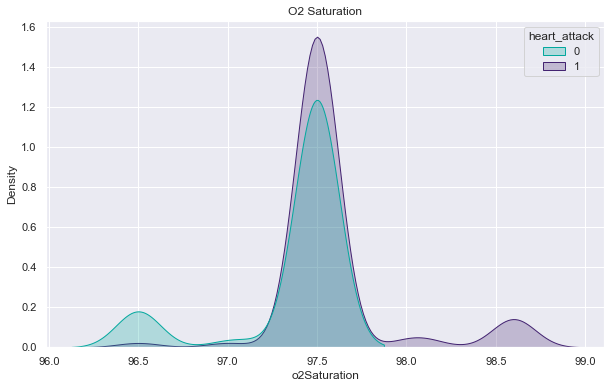

In [33]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.kdeplot(data=df,x='o2Saturation', hue='heart_attack', fill=True, palette = ['#03A89E', '#432371']).set(
    title="O2 Saturation")

For both groups (with high and low chance of getting heart attack) the oxygen saturation level in most cases equals to 97.5

In [34]:
def scatter_linear_plt(x,y,hue,df):
    sns.lmplot(x=x, y=y, hue=hue, data=df,
               markers=["o", "x"], palette=['#7CCD7C','#191970'])

Text(0.5, 1.0, 'Max heart rate & Age')

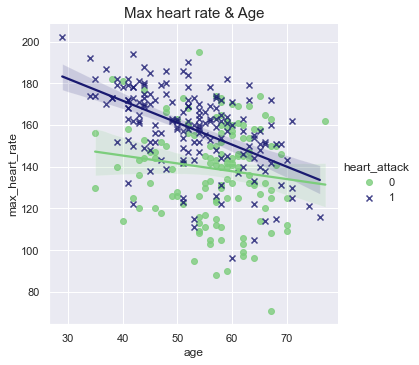

In [35]:
scatter_linear_plt('age','max_heart_rate','heart_attack',df)
plt.title('Max heart rate & Age', fontsize=15)

According to the plot, it can be seen that:
- people with more chances of heart attack in their 30s-40s have higher maximum heart rate (around 180 - 170 bpm)  than people in 60s-70s (max heart rate is around 140 - 150 bpm).
- people with less chances of heart attack have maximum heart rate in a range between 130 - 150 bpm accross all ages groups.

Text(0.5, 1.0, 'Blood pressure & Age')

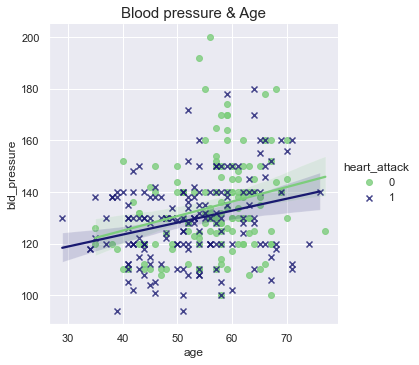

In [36]:
scatter_linear_plt('age','bld_pressure','heart_attack',df)
plt.title('Blood pressure & Age', fontsize=15)

According to the plot, it can be seen that:
- for both groups the value of resting blood pressure increases with age (from 120 to around 140mm Hg)

# Prediction Models

Setting target variable and predictors

In [37]:
X = df.drop(["heart_attack"], axis = 1)
y = df[["heart_attack"]]

Data Scaling

In [38]:
scaler = RobustScaler()

# scaling the continuous features
X[con_features] = scaler.fit_transform(X[con_features])

In [39]:
X.head()

,age,sex,cp,bld_pressure,chol,fbs,restecg,max_heart_rate,angina,oldpeak,slp,n_vessels,thall,o2Saturation
0,0.592593,1,3,0.75,-0.110236,1,0,-0.092308,0,0.9375,0,0,1,1.1
1,-1.333333,1,2,0.00,0.157480,0,1,1.046154,0,1.6875,0,0,2,1.1
2,-1.037037,0,1,0.00,-0.566929,0,0,0.584615,0,0.3750,2,0,2,1.1
3,0.074074,1,1,-0.50,-0.062992,0,1,0.769231,0,0.0000,2,0,2,1.1
4,0.148148,0,0,-0.50,1.795276,0,1,0.307692,1,-0.1250,2,0,2,0.6


Splitting data to test and train

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

SVC model (Linear Kernel)

In [41]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)

In [42]:
print('SVC model Accuracy:',metrics.accuracy_score(y_test, y_pred_svc))
print('SVC model Precision:',metrics.precision_score(y_test, y_pred_svc))
print('SVC model Recall:',metrics.recall_score(y_test, y_pred_svc))

SVC model Accuracy: 0.8947368421052632
SVC model Precision: 0.8461538461538461
SVC model Recall: 0.9428571428571428


KNN model

In [43]:
#find the best value for k
k_values = [i for i in range (1,21)]
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=3)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

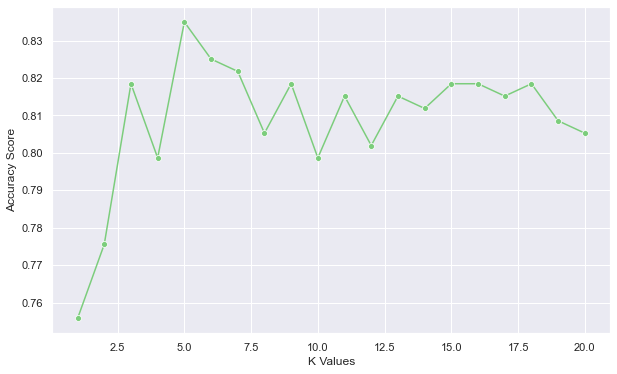

In [44]:
sns.lineplot(x = k_values, y = scores, marker = 'o', color='#7CCD7C')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [45]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [46]:
y_pred_knn = knn.predict(X_test)

In [47]:
print('KNN model Accuracy: ', metrics.accuracy_score(y_test, y_pred_knn))
print('KNN model Precision: ',metrics.precision_score(y_test, y_pred_knn))
print('KNN model Recall: ',metrics.recall_score(y_test, y_pred_knn))

KNN model Accuracy:  0.8421052631578947
KNN model Precision:  0.7804878048780488
KNN model Recall:  0.9142857142857143


<AxesSubplot:>

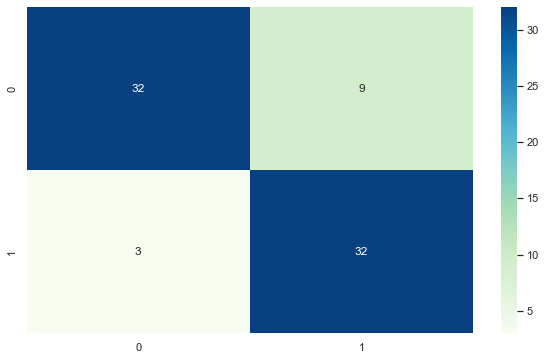

In [48]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot = True, fmt='d', cmap='GnBu')

Logistic Regression

In [49]:
logreg=LogisticRegression(max_iter=100,random_state=1,n_jobs=-1)
logreg.fit(X_train,y_train)
y_pred_lr=logreg.predict(X_test)
y_pred_lr

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1])

In [50]:
print('Logistic Regression model Accuracy: ', metrics.accuracy_score(y_test, y_pred_lr))
print('Logistic Regressio model Precision: ',metrics.precision_score(y_test, y_pred_lr))
print('Logistic Regressio model Recall: ',metrics.recall_score(y_test, y_pred_lr))

Logistic Regression model Accuracy:  0.868421052631579
Logistic Regressio model Precision:  0.8205128205128205
Logistic Regressio model Recall:  0.9142857142857143


<AxesSubplot:>

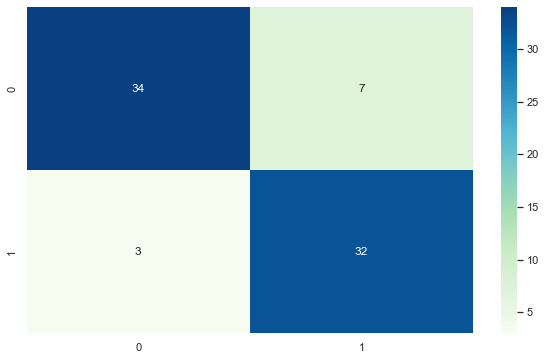

In [51]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot = True, fmt="d", cmap='GnBu')

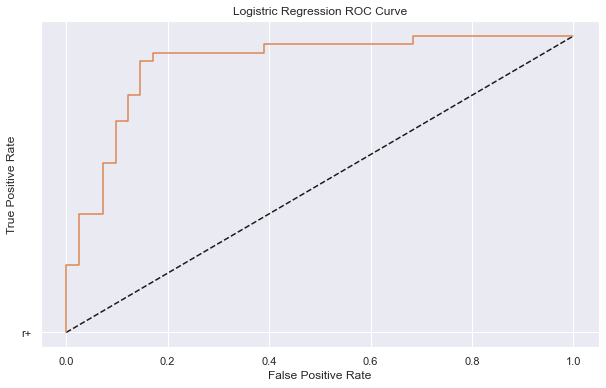

In [52]:
#ROC curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr,tpr,threshols=metrics.roc_curve(y_test,y_pred_prob)

plt.plot([0,1],[0,1],"k--",'r+')
plt.plot(fpr,tpr,label='Logistic Regression ROC curve')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistric Regression ROC Curve")
plt.show()

Among three implemented models, SVC, KNN and LR, the highest accuracy of 89.5% was achived with SVM classifier.